In [9]:
import hw1_v3 as hw1
import yahoofinancials as yfs
import yfinance as yf
import numpy as np
import os
import pandas as pd
import JT_2 as JT

#import Hull_imlied_pds as hull

ModuleNotFoundError: No module named 'yahoofinancials'

***


## Companies: GE, AAPL, TSLA, MSFT,  GS

### 1. Take credit issuers you were assigned and perform the following steps:
- Find their public ratings from major providers – lookup PD’s for one year, also look up cumulative PD’s for each of the ratings over 5-year time periods

- Calculate their Altman’s Z scores based on available data – does Z score agree with public ratings? What would you change based on this information?

- Perform Merton model analysis on each of the issuers, calculate their DD’s and implied PD’s over 5 years

- Obtain credit spreads for each of the issuers, calculate and draw default intensity step term structure (using Hull approach) – is it different from above steps, why?

- Calculate implied JT-model π’s from the generic issuer with the same rating (i.e. look at generic 5-yr spread for issuer in the same rating category, solve back for π using 5-year cumulative transition matrix), apply those π’s to your issuers PD’s calculated from Hull above, then – what should their 5-year credit spreads be? Are they consistent with the market pricing? Why yes, or why no?

### 2. Compare PD’s from each of the steps above; write about how you would you use these estimates together
### 3. Write up your findings in the clear concise summary



***

In [93]:
rf_df = np.array([1.59 , 1.62, 1.59,1.6, 1.61])
rf =rf_df/100
rf

array([0.0159, 0.0162, 0.0159, 0.016 , 0.0161])

In [39]:
def get_equity_vol(ticker,start_date,end_date,interval):
    '''param ticker: could be list or string, could be one or multiple
       param start_date: in format 'YYYY-MM-DD'
       param end_date: in format 'YYYY-MM-DD'
       param interval: valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    '''
    
    return yf.download(tickers=ticker,start=start_date, end=end_date,interval=interval)[
        'Adj Close'].pct_change().std()*np.sqrt(252)
    

In [40]:
tickers=["AAPL","GE","TSLA","MSFT","GS"]
start="2018-10-01"
end="2019-10-01"
interval='1d'

vol = get_equity_vol(ticker=tickers,start_date=start,end_date=end,interval=interval)

[*********************100%***********************]  5 of 5 downloaded


In [41]:
vol

AAPL    0.320813
GE      0.462401
GS      0.280134
MSFT    0.269190
TSLA    0.518855
dtype: float64

**Note**:

- Used 1 yr of stock prices (from 2018-10-1 to 2019-10-1)
- Annulized volatility



# 1. AAPL


## 1.0 PD, Conditional PD...


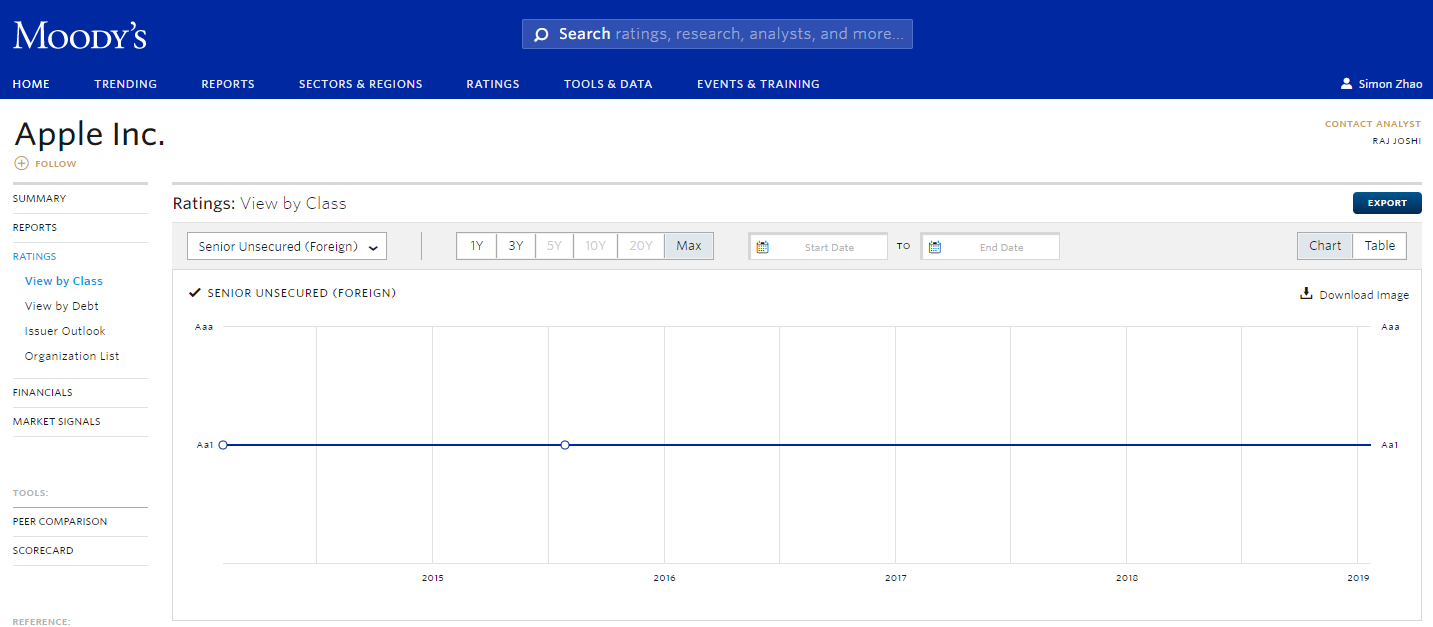
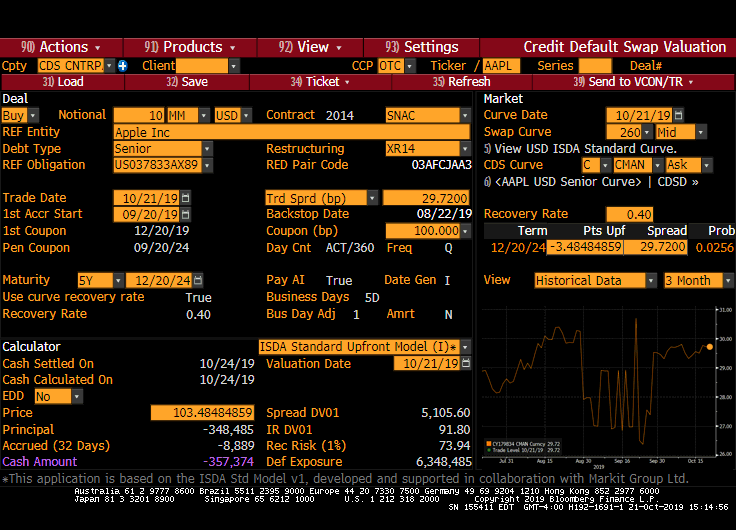

In [43]:

aapl_totalAsset = yfs.YahooFinancials('AAPL').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["AAPL"][0]['2018-09-29']['totalAssets'];

aapl_totalCurrLib = yfs.YahooFinancials('AAPL').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["AAPL"][0]['2018-09-29']['totalCurrentLiabilities'];

aapl_totalCurrAsset = yfs.YahooFinancials('AAPL').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["AAPL"][0]['2018-09-29']['totalCurrentAssets'];

aapl_RetainedEarning = yfs.YahooFinancials('AAPL').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["AAPL"][0]['2018-09-29']['retainedEarnings'];

aapl_EBIT = yfs.YahooFinancials('AAPL').get_financial_stmts('annual','income')\
["incomeStatementHistory"]["AAPL"][0]['2018-09-29']['ebit']

aapl_mkt_val = yfs.YahooFinancials('AAPL').get_market_cap()

aapl_sales = yfs.YahooFinancials('AAPL').get_total_revenue()


In [44]:
# Working Capital
aapl_working_cap = aapl_totalCurrAsset-aapl_totalCurrLib
aapl_working_cap

14473000000

In [45]:
# Book Value of Debt

aapl_longtermDebt = yfs.YahooFinancials('AAPL').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["AAPL"][0]['2018-09-29']['longTermDebt'];

aapl_accountsPayable = yfs.YahooFinancials('AAPL').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["AAPL"][0]['2018-09-29']['accountsPayable'];

aapl_book_val_debt = aapl_accountsPayable+aapl_longtermDebt+aapl_totalCurrLib

**Note:**
- Book Value of Debt = Long Term Debt + Notes Payable + Current Portion of Long-Term Debt
- I used _accountsPayable_ as  _Notes Payable_
- _Total current debt_ as _Curent Portion of Long-Term Debt_

## 1.1 Altman's Z

In [46]:
aapl_altman_z=hw1.calc_altman_z(total_assets=aapl_totalAsset,
                                working_capital=aapl_working_cap,
                                retained_earnings=aapl_RetainedEarning,
                                ebit=aapl_EBIT,
                                mv_equity=aapl_mkt_val,
                                sales=aapl_sales,
                               book_value_debt=aapl_book_val_debt)
aapl_altman_z

5.4576780977069905

Z > 2.8, bankruptcy risk is low.

## 1.2 Merton

In [47]:
aapl_totalLib = yfs.YahooFinancials('AAPL').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["AAPL"][0]['2018-09-29']['totalLiab'];


In [48]:
dict_profile = {}
for num in range(1, 6):
    aapl_DD_Merton,aapl_PD_Merton =hw1.calc_prob_default(assets=aapl_totalAsset,
                                                         equity=aapl_mkt_val,
                                                         debt=aapl_totalLib,
                                                         t=num,
                                                         equity_vol=vol['AAPL'],
                                                         rf=0.0173)
    dict_profile.update({num: (aapl_DD_Merton, aapl_PD_Merton)})
    
dict_profile

{1: (1.654047581454325, 0.04905892267728175),
 2: (3.5334190975576454, 0.00020511080962098654),
 3: (3.4973889521884103, 0.00023491813621676075),
 4: (2.982675839275498, 0.0014287022841618965),
 5: (2.6213798981171688, 0.00437873065255329)}

In [49]:
aapl_merton=pd.DataFrame.from_dict(dict_profile, orient='index',columns=['AAPL_DD', 'AAPL_PD'])
print(aapl_merton)

    AAPL_DD   AAPL_PD
1  1.654048  0.049059
2  3.533419  0.000205
3  3.497389  0.000235
4  2.982676  0.001429
5  2.621380  0.004379


## 1.3 JT

In [50]:
aapl_risk_neutral_transition,aapl_pi = JT.solve_pi(spread=aapl_spread, 
                                                   rf_rates=rf_df, 
                                                   lst_transitions=JT.transitions_matrices, 
                                                   rating='AA')

In [51]:
aapl_risk_neutral_transition

[array([1.11186817e-03, 9.71224852e-01, 1.74563303e-02, 1.08963081e-03,
        1.11186817e-04, 1.33424181e-04, 4.44747270e-05]),
 array([9.52940456e-04, 9.73640986e-01, 1.48783501e-02, 1.41806615e-03,
        2.21218320e-04, 1.58823409e-04, 2.83613231e-05]),
 array([6.95928158e-04, 9.80225024e-01, 1.08399657e-02, 1.18543695e-03,
        2.00521673e-04, 1.29749318e-04, 1.76930888e-05]),
 array([5.80886326e-04, 9.81922113e-01, 9.39979692e-03, 1.22558214e-03,
        2.00229756e-04, 1.29819293e-04, 1.54022890e-05]),
 array([5.14833448e-04, 9.82851815e-01, 8.58290830e-03, 1.25534731e-03,
        2.00996620e-04, 1.30471490e-04, 1.41050260e-05])]

In [52]:
pd.DataFrame(aapl_risk_neutral_transition)

,0,1,2,3,4,5,6
0,0.001112,0.971225,0.017456,0.001090,0.000111,0.000133,0.000044
1,0.000953,0.973641,0.014878,0.001418,0.000221,0.000159,0.000028
2,0.000696,0.980225,0.010840,0.001185,0.000201,0.000130,0.000018
3,0.000581,0.981922,0.009400,0.001226,0.000200,0.000130,0.000015
4,0.000515,0.982852,0.008583,0.001255,0.000201,0.000130,0.000014


In [53]:
aapl_pi

[0.22237363475448438,
 0.11344529236224289,
 0.058976962517573985,
 0.04400653987856908,
 0.03526256490985918]

## 1.4 Hull

Here, we determined the following implied default probabilities for AAPL using the securities in the enclosed folder:

In [1]:
A1 = 0.0114393
A3 = 0.000994527
A13 = 0.00436698
A5 = 0.0268201
A35 = 0.0777127

Below is a step curve of the default intensity term structure:

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
x0 = np.array([1, 3, 5])
y0 = np.array([A1, A13, A35])

[]

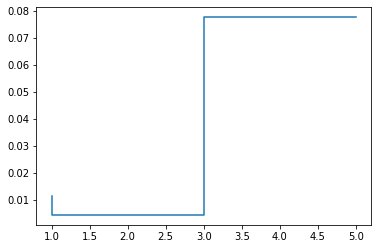

In [15]:
plt.step(x0, y0)
plt.plot()

# 2.  GE


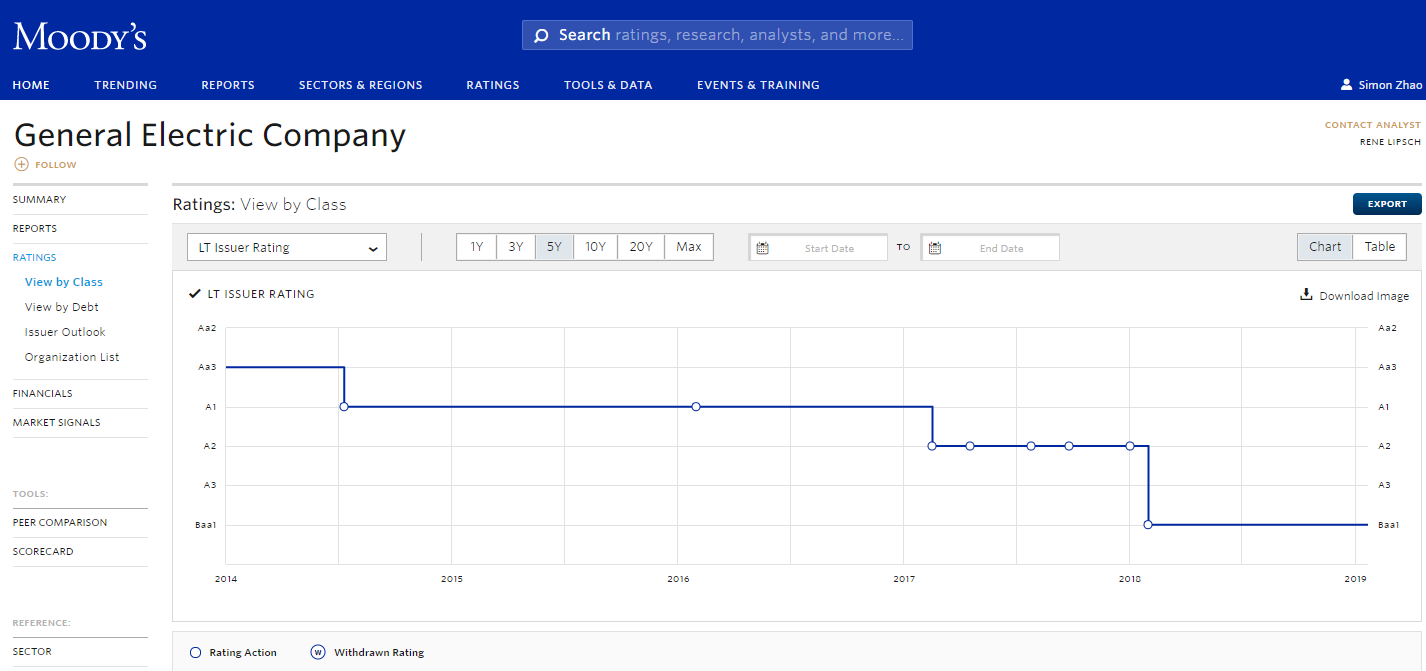
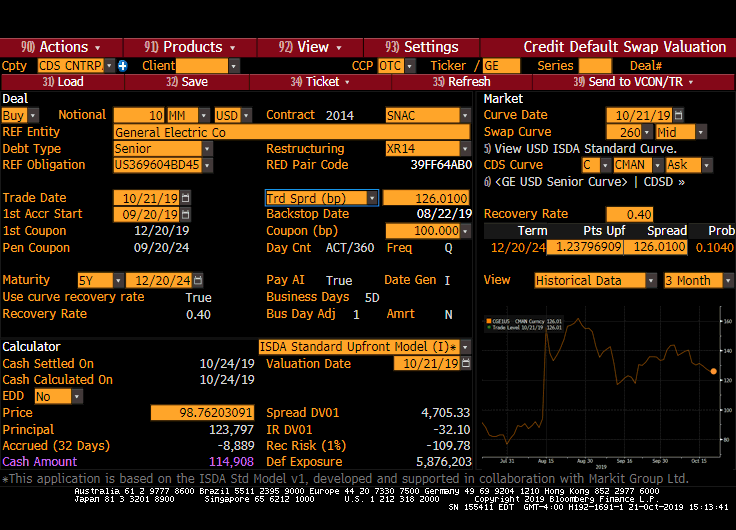

In [54]:
ge_totalAsset = yfs.YahooFinancials('GE').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GE"][0]['2018-12-31']['totalAssets'];

ge_totalCurrLib = yfs.YahooFinancials('GE').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GE"][0]['2018-12-31']['totalCurrentLiabilities'];

ge_totalCurrAsset = yfs.YahooFinancials('GE').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GE"][0]['2018-12-31']['totalCurrentAssets'];

ge_RetainedEarning = yfs.YahooFinancials('GE').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GE"][0]['2018-12-31']['retainedEarnings'];

ge_EBIT = yfs.YahooFinancials('GE').get_financial_stmts('annual','income')\
["incomeStatementHistory"]["GE"][0]['2018-12-31']['ebit']

ge_mkt_val = yfs.YahooFinancials('GE').get_market_cap()

ge_sales = yfs.YahooFinancials('GE').get_total_revenue()


In [55]:
# Working Capital
ge_working_cap = ge_totalCurrAsset-ge_totalCurrLib
ge_working_cap

46037000000

In [56]:
# Book Value of Debt

ge_longtermDebt = yfs.YahooFinancials('GE').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GE"][0]['2018-12-31']['longTermDebt'];

ge_accountsPayable = yfs.YahooFinancials('GE').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GE"][0]['2018-12-31']['accountsPayable'];

ge_book_val_debt = ge_accountsPayable+ge_longtermDebt+ge_totalCurrLib

## 2.1 Altman's Z

In [57]:
ge_altman_z=hw1.calc_altman_z(total_assets=ge_totalAsset,
                                working_capital=ge_working_cap,
                                retained_earnings=ge_RetainedEarning,
                                ebit=ge_EBIT,
                                mv_equity=ge_mkt_val,
                                sales=ge_sales,
                                book_value_debt=ge_book_val_debt)
ge_altman_z

1.409350822405921

Z < 1.8, bankruptcy risk is high.

## 2.2 Merton

In [58]:
ge_totalLib = yfs.YahooFinancials('GE').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GE"][0]['2018-12-31']['totalLiab'];

ge_volume = yfs.YahooFinancials('GE').get_current_volume()

In [59]:
ge_dict_profile = {}
for num in range(1, 6):
    ge_DD_Merton,ge_PD_Merton =hw1.calc_prob_default(assets=ge_totalAsset,
                                                         equity=ge_mkt_val,
                                                         debt=ge_totalLib,
                                                         t=num,
                                                         equity_vol=vol['GE'],
                                                         rf=0.0173)
    ge_dict_profile.update({num: (ge_DD_Merton, ge_PD_Merton)})
    
ge_dict_profile

{1: (1.0620583412441733, 0.1441046002766166),
 2: (0.28175875374656895, 0.3890642498818217),
 3: (0.6479757463273036, 0.2585003186419357),
 4: (0.2897258448203504, 0.3860129913195373),
 5: (0.3646186223016192, 0.35769805596286586)}

In [60]:
ge_merton=pd.DataFrame.from_dict(ge_dict_profile, orient='index',columns=['GE_DD', 'GE_PD'])

## 2.3 JT

In [61]:
ge_risk_neutral_transition,ge_pi = JT.solve_pi(spread=ge_spread, 
                                               rf_rates=rf_df, 
                                               lst_transitions=JT.transitions_matrices, 
                                               rating='BBB')

In [62]:
pd.DataFrame(ge_risk_neutral_transition)

,0,1,2,3,4,5,6
0,0.000031,0.000283,0.010740,0.956162,0.011368,0.001445,0.000345
1,0.000025,0.000304,0.009910,0.958746,0.008981,0.001715,0.000329
2,0.000016,0.000218,0.006703,0.971875,0.005654,0.001266,0.000226
3,0.000013,0.000222,0.006033,0.973432,0.004684,0.001191,0.000212
4,0.000012,0.000243,0.006065,0.972291,0.004387,0.001238,0.000220


In [63]:
ge_pi

[0.314022516222994,
 0.16897062561285403,
 0.0806565283957557,
 0.06421158769075341,
 0.05787114011312412]

## 2.4 Hull

Here, we determined the following implied default probabilities for GE using the securities in the enclosed folder:

In [20]:
A1 = 0.0212192
A3 = 0.0162346
A13 = 0.0136163
A5 = 0.0371634
A35 = 0.0795522

Below is a step curve of the default intensity term structure:

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
x0 = np.array([1, 3, 5])
y0 = np.array([A1, A13, A35])

[]

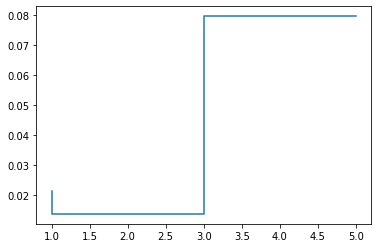

In [22]:
plt.step(x0, y0)
plt.plot()

# 3. TSLA

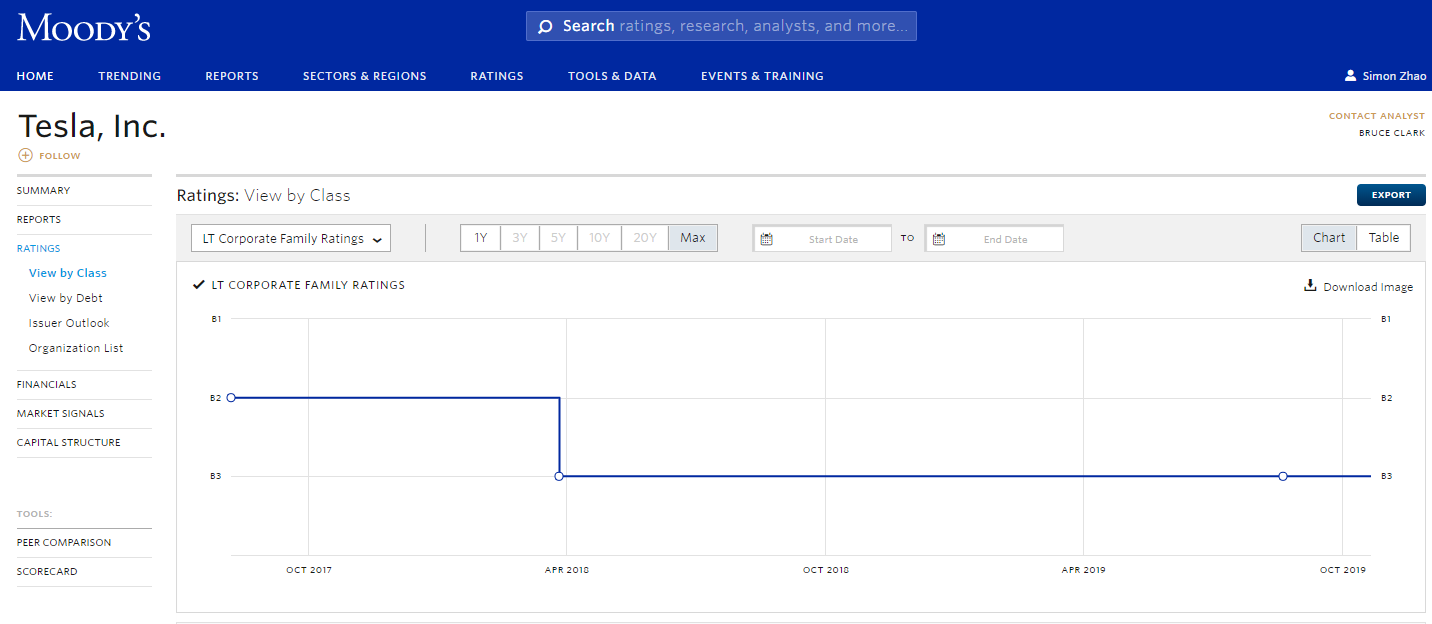

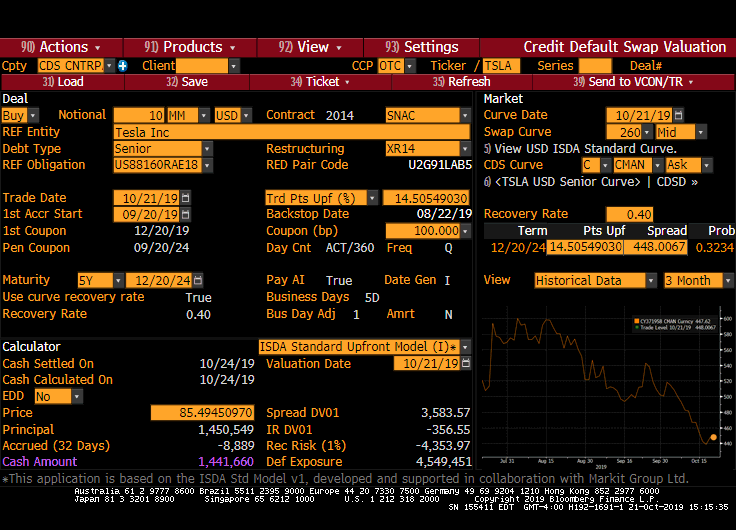

In [64]:
tsla_totalAsset = yfs.YahooFinancials('TSLA').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["TSLA"][0]['2018-12-31']['totalAssets'];

tsla_totalCurrLib = yfs.YahooFinancials('TSLA').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["TSLA"][0]['2018-12-31']['totalCurrentLiabilities'];

tsla_totalCurrAsset = yfs.YahooFinancials('TSLA').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["TSLA"][0]['2018-12-31']['totalCurrentAssets'];

tsla_RetainedEarning = yfs.YahooFinancials('TSLA').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["TSLA"][0]['2018-12-31']['retainedEarnings'];

tsla_EBIT = yfs.YahooFinancials('TSLA').get_financial_stmts('annual','income')\
["incomeStatementHistory"]["TSLA"][0]['2018-12-31']['ebit']

tsla_mkt_val = yfs.YahooFinancials('TSLA').get_market_cap()

tsla_sales = yfs.YahooFinancials('TSLA').get_total_revenue()

In [65]:
# Working Capital
tsla_working_cap = tsla_totalCurrAsset-tsla_totalCurrLib
tsla_working_cap

-1685828000

In [66]:
# Book Value of Debt

tsla_longtermDebt = yfs.YahooFinancials('TSLA').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["TSLA"][0]['2018-12-31']['longTermDebt'];

tsla_accountsPayable = yfs.YahooFinancials('TSLA').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["TSLA"][0]['2018-12-31']['accountsPayable'];

tsla_book_val_debt = tsla_accountsPayable+tsla_longtermDebt+tsla_totalCurrLib

## 3.1 Altman's Z

In [67]:
tsla_altman_z=hw1.calc_altman_z(total_assets=tsla_totalAsset,
                                working_capital=tsla_working_cap,
                                retained_earnings=tsla_RetainedEarning,
                                ebit=tsla_EBIT,
                                mv_equity=tsla_mkt_val,
                                sales=tsla_sales,
                                book_value_debt=tsla_book_val_debt)
tsla_altman_z

2.179009261924065

1.8 < Z < 2.8, bankruptcy risk is moderate.

## 3.2 Merton

In [68]:
tsla_totalLib = yfs.YahooFinancials('TSLA').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["TSLA"][0]['2018-12-31']['totalLiab'];

tsla_volume = yfs.YahooFinancials('TSLA').get_current_volume()

In [69]:
tsla_dict_profile = {}
for num in range(1, 6):
    tsla_DD_Merton,tsla_PD_Merton =hw1.calc_prob_default(assets=tsla_totalAsset,
                                                         equity=tsla_mkt_val,
                                                         debt=tsla_totalLib,
                                                         t=num,
                                                         equity_vol=vol['TSLA'],
                                                         rf=0.0173)
    tsla_dict_profile.update({num: (tsla_DD_Merton, tsla_PD_Merton)})
    
tsla_dict_profile

{1: (1.3223527812824256, 0.09302535227852987),
 2: (1.1941757493743776, 0.11620461356533784),
 3: (1.296019481938486, 0.09748438651626179),
 4: (1.1238914447952975, 0.13052954056840776),
 5: (0.9130579356369937, 0.18060603595616842)}

In [70]:
tsla_merton=pd.DataFrame.from_dict(tsla_dict_profile, orient='index',columns=['TSLA_DD', 'TSLA_PD'])

## 3.3 JT

In [71]:
tsla_risk_neutral_transition,tsla_pi = JT.solve_pi(spread=tsla_spread, 
                                                   rf_rates=rf_df, 
                                                   lst_transitions=JT.transitions_matrices, 
                                                   rating='CCC/C')

In [72]:
pd.DataFrame(tsla_risk_neutral_transition)

,0,1,2,3,4,5,6
0,0.0,0.0,0.000264,0.000480,0.001416,0.031693,0.864469
1,0.0,0.0,0.000277,0.000934,0.002515,0.035169,0.831156
2,0.0,0.0,0.000149,0.000697,0.001818,0.019754,0.897239
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3.4 Hull

Here, we determined the following implied default probabilities for TSLA using the securities in the enclosed folder:

In [23]:
A2 = 0.00626101
A3 = 0.0117387
A23 = 0.0145951
A5 = 0.00515502
A35 = 0.00709085

Below is a step curve of the default intensity term structure:

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
x0 = np.array([1, 3, 5])
y0 = np.array([A1, A23, A35])

[]

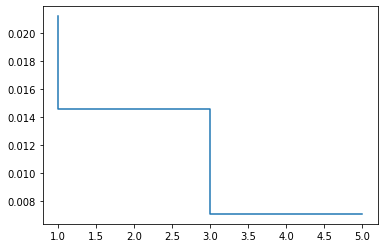

In [26]:
plt.step(x0, y0)
plt.plot()

# 4. MSFT

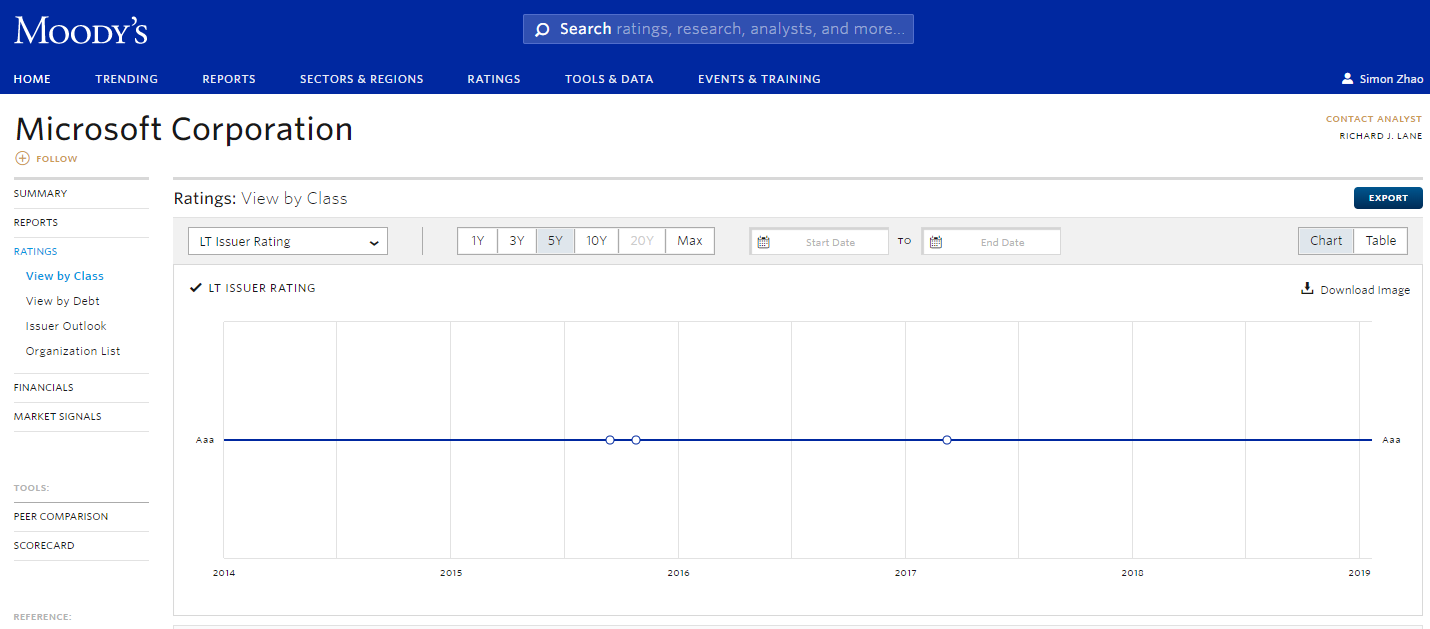
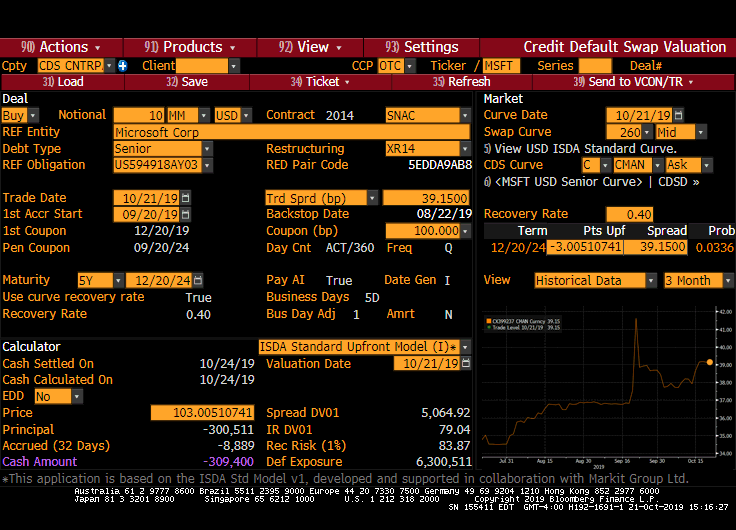

In [73]:
msft_totalAsset = yfs.YahooFinancials('MSFT').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["MSFT"][0]['2019-06-30']['totalAssets'];

msft_totalCurrLib = yfs.YahooFinancials('MSFT').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["MSFT"][0]['2019-06-30']['totalCurrentLiabilities'];

msft_totalCurrAsset = yfs.YahooFinancials('MSFT').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["MSFT"][0]['2019-06-30']['totalCurrentAssets'];

msft_RetainedEarning = yfs.YahooFinancials('MSFT').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["MSFT"][0]['2019-06-30']['retainedEarnings'];

msft_EBIT = yfs.YahooFinancials('MSFT').get_financial_stmts('annual','income')\
["incomeStatementHistory"]["MSFT"][0]['2019-06-30']['ebit']

msft_mkt_val = yfs.YahooFinancials('MSFT').get_market_cap()
msft_sales = yfs.YahooFinancials('MSFT').get_total_revenue()


In [74]:
# Working Capital
msft_working_cap = msft_totalCurrAsset-msft_totalCurrLib
msft_working_cap

106132000000

In [75]:
# Book Value of Debt

msft_longtermDebt = yfs.YahooFinancials('MSFT').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["MSFT"][0]['2019-06-30']['longTermDebt'];

msft_accountsPayable = yfs.YahooFinancials('MSFT').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["MSFT"][0]['2019-06-30']['accountsPayable'];

msft_book_val_debt = msft_accountsPayable+msft_longtermDebt+msft_totalCurrLib

## 4.1 Altman's Z

In [76]:
msft_altman_z=hw1.calc_altman_z(total_assets=msft_totalAsset,
                                working_capital=msft_working_cap,
                                retained_earnings=msft_RetainedEarning,
                                ebit=msft_EBIT,
                                mv_equity=msft_mkt_val,
                                sales=msft_sales,
                                book_value_debt=msft_book_val_debt)
msft_altman_z

8.4204453049759

Z > 2.8, bankruptcy risk is low.

## 4.2 Merton

In [77]:
msft_totalLib = yfs.YahooFinancials('MSFT').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["MSFT"][0]['2019-06-30']['totalLiab'];

msft_volume = yfs.YahooFinancials('MSFT').get_current_volume()

In [78]:
msft_dict_profile = {}
for num in range(1, 6):
    msft_DD_Merton,msft_PD_Merton =hw1.calc_prob_default(assets=msft_totalAsset,
                                                         equity=msft_mkt_val,
                                                         debt=msft_totalLib,
                                                         t=num,
                                                         equity_vol=vol['MSFT'],
                                                         rf=0.0173)
    msft_dict_profile.update({num: (msft_DD_Merton, msft_PD_Merton)})
    
msft_dict_profile

{1: (1.8187199749446987, 0.03447708133536595),
 2: (4.939880558133799, 3.908521971188227e-07),
 3: (4.647886417749998, 1.676767368633483e-06),
 4: (3.9887973688103964, 3.3204558583956476e-05),
 5: (3.53481959585338, 0.00020402682251810503)}

In [79]:
msft_merton=pd.DataFrame.from_dict(msft_dict_profile, orient='index',columns=['MSFT_DD', 'MSFT_PD'])
msft_merton

,MSFT_DD,MSFT_PD
1,1.818720,3.447708e-02
2,4.939881,3.908522e-07
3,4.647886,1.676767e-06
4,3.988797,3.320456e-05
5,3.534820,2.040268e-04


## 4.3 JT

In [80]:
msft_risk_neutral_transition,msft_pi = JT.solve_pi(spread=msft_spread, 
                                                   rf_rates=rf_df, 
                                                   lst_transitions=JT.transitions_matrices, 
                                                   rating='AAA')

In [81]:
pd.DataFrame(msft_risk_neutral_transition)

,0,1,2,3,4,5,6
0,0.970194,0.020894,0.001214,0.000115,0.000183,0.000069,0.000115
1,0.970973,0.019102,0.001750,0.000226,0.000165,0.000067,0.000110
2,0.976466,0.015107,0.001592,0.000218,0.000129,0.000054,0.000088
3,0.980295,0.011781,0.001653,0.000259,0.000100,0.000056,0.000049
4,0.980061,0.011319,0.001894,0.000316,0.000095,0.000063,0.000032


In [82]:
msft_pi

[0.2290994843739861,
 0.12193753428774562,
 0.06801680700929004,
 0.04630040967731532,
 0.039468040864196086]

## 4.4 Hull

Here, we determined the following implied default probabilities for MSFT using the securities in the enclosed folder:

In [27]:
A1 = 0.0199685
A3 = 0.0103892
A13 = 0.00639242
A5 = 0.0176101
A35 = 0.0449971

Below is a step curve of the default intensity term structure:

In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
x0 = np.array([1, 3, 5])
y0 = np.array([A1, A13, A35])

[]

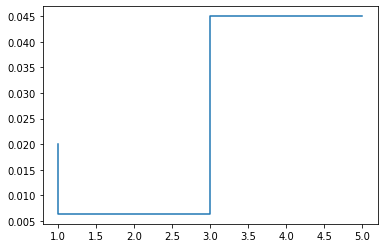

In [30]:
plt.step(x0, y0)
plt.plot()

# 5. GS

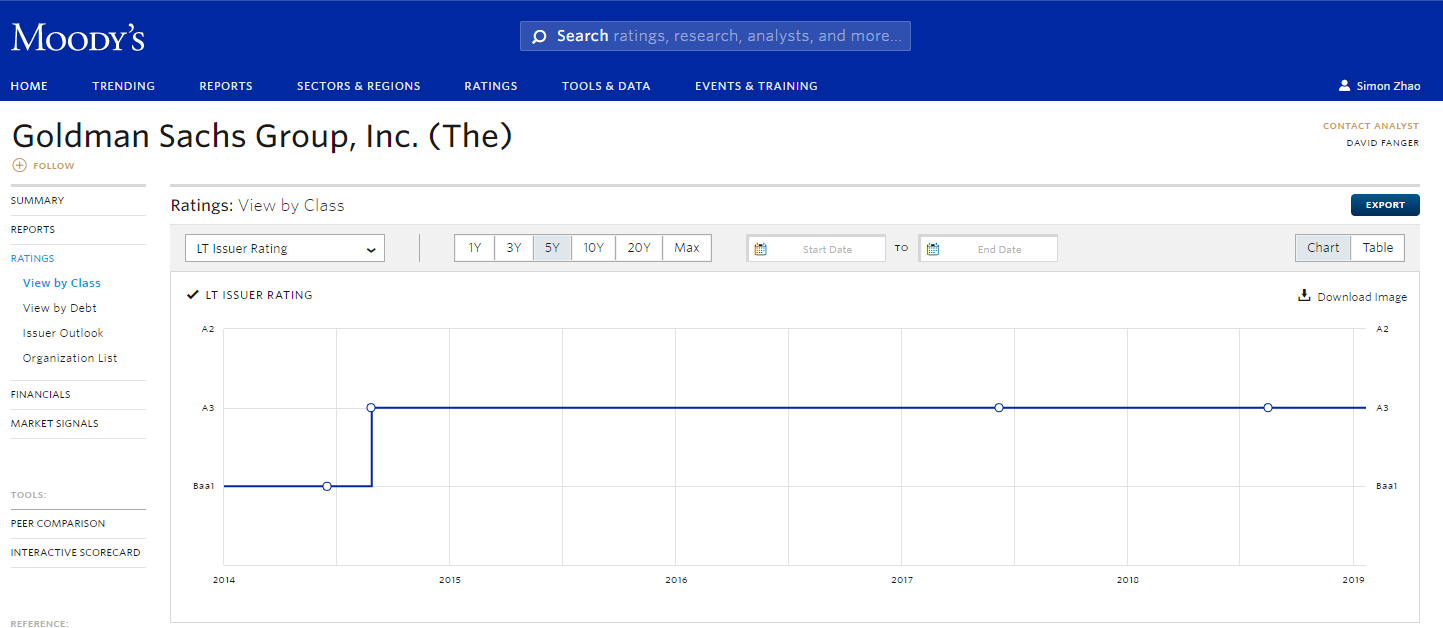
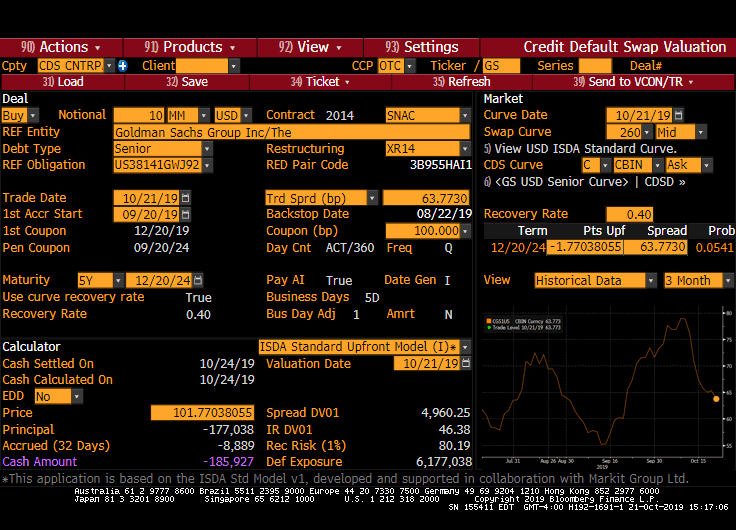


In [83]:
gs_totalAsset = yfs.YahooFinancials('GS').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GS"][0]['2018-12-31']['totalAssets'];

gs_totalCurrLib = yfs.YahooFinancials('GS').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GS"][0]['2018-12-31']['totalCurrentLiabilities'];

gs_totalCurrAsset = yfs.YahooFinancials('GS').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GS"][0]['2018-12-31']['totalCurrentAssets'];

gs_RetainedEarning = yfs.YahooFinancials('GS').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GS"][0]['2018-12-31']['retainedEarnings'];

gs_EBIT = yfs.YahooFinancials('GS').get_financial_stmts('annual','income')\
["incomeStatementHistory"]["GS"][0]['2018-12-31']['ebit']

gs_mkt_val = yfs.YahooFinancials('GS').get_market_cap()

gs_sales = yfs.YahooFinancials('GS').get_total_revenue()

In [84]:
# Working Capital
gs_working_cap = gs_totalCurrAsset-gs_totalCurrLib
gs_working_cap

427413000000

In [85]:
# Book Value of Debt

gs_longtermDebt = yfs.YahooFinancials('GS').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GS"][0]['2018-12-31']['longTermDebt'];

gs_accountsPayable = yfs.YahooFinancials('GS').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GS"][0]['2018-12-31']['accountsPayable'];

gs_book_val_debt = gs_accountsPayable+gs_longtermDebt+gs_totalCurrLib

## 5.1 Altman's Z

In [86]:
gs_altman_z=hw1.calc_altman_z(total_assets=gs_totalAsset,
                                working_capital=gs_working_cap,
                                retained_earnings=gs_RetainedEarning,
                                ebit=gs_EBIT,
                                mv_equity=gs_mkt_val,
                                sales=gs_sales,
                                book_value_debt=gs_book_val_debt)
gs_altman_z

0.808012313162223

Z < 1.8, bankruptcy risk is high.

## 5.2 Merton

In [87]:
gs_totalLib = yfs.YahooFinancials('GS').get_financial_stmts('annual','balance')\
["balanceSheetHistory"]["GS"][0]['2018-12-31']['totalLiab'];

gs_volume = yfs.YahooFinancials('GS').get_current_volume()

In [88]:
gs_dict_profile = {}
for num in range(1, 6):
    gs_DD_Merton,gs_PD_Merton =hw1.calc_prob_default(assets=gs_totalAsset,
                                                         equity=gs_mkt_val,
                                                         debt=gs_totalLib,
                                                         t=num,
                                                         equity_vol=vol['GS'],
                                                         rf=0.0173)
    gs_dict_profile.update({num: (gs_DD_Merton, gs_PD_Merton)})
    
gs_dict_profile

{1: (1.1530271098324454, 0.12444962869303666),
 2: (0.26283543823441036, 0.3963387098940684),
 3: (2.401765094313421, 0.008158091094627298),
 4: (1.8434665448848597, 0.03263046098777749),
 5: (1.5479183718030105, 0.06082097539033652)}

In [89]:
gs_merton=pd.DataFrame.from_dict(gs_dict_profile, orient='index',columns=['GS_DD', 'GS_PD'])

## 5.3 JT

In [90]:
gs_risk_neutral_transition,gs_pi = JT.solve_pi(spread=gs_spread, 
                                               rf_rates=rf_df, 
                                               lst_transitions=JT.transitions_matrices, 
                                               rating='AA')

In [91]:
pd.DataFrame(gs_risk_neutral_transition)

,0,1,2,3,4,5,6
0,0.001396,0.963866,0.021920,0.001368,0.000140,0.000168,0.000056
1,0.001270,0.964859,0.019835,0.001891,0.000295,0.000212,0.000038
2,0.000912,0.974077,0.014210,0.001554,0.000263,0.000170,0.000023
3,0.000799,0.975123,0.012935,0.001687,0.000276,0.000179,0.000021
4,0.000743,0.975252,0.012387,0.001812,0.000290,0.000188,0.000020


In [92]:
gs_pi

[0.27924195852183703,
 0.15124191923878283,
 0.07731426706164653,
 0.06055741278403703,
 0.050889746669583465]

# JT:

### Risk Free Rates

- Risk free rates can be find [here](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/TextView.aspx?data=yieldYear&year=2019).
- OAS of companies can be find [here](https://fred.stlouisfed.org/series/BAMLC0A1CAAA).

In [94]:
ge_oas_df = pd.read_csv("BAMLC0A4CBBB.csv")
ge_spread = np.array(ge_oas_df[-5:]["BAMLC0A4CBBB"])/100
ge_spread

array([0.02049385, 0.02111756, 0.01463   , 0.01486628, 0.01632967])

In [95]:
aapl_oas_df = pd.read_csv("BAMLC0A2CAA.csv")
aapl_spread = np.array(aapl_oas_df[-5:]["BAMLC0A2CAA"])/100
aapl_spread

array([0.00917846, 0.00915076, 0.00696577, 0.00680498, 0.00675072])

In [96]:
tsla_oas_df = pd.read_csv("BAMLH0A3HYC.csv")
tsla_spread = np.array(tsla_oas_df[-5:]["BAMLH0A3HYC"])/100
tsla_spread

array([0.10980423, 0.14365344, 0.08599885, 0.07666398, 0.09714641])

In [97]:
msft_oas_df = pd.read_csv("BAMLC0A1CAAA.csv")
msft_spread = np.array(msft_oas_df[-5:]["BAMLC0A1CAAA"])/100
msft_spread

array([0.00749808, 0.00799847, 0.00659115, 0.00605479, 0.00651005])

In [98]:
gs_oas_df = pd.read_csv("BAMLC0A3CA.csv")
gs_spread = np.array(gs_oas_df[-5:]["BAMLC0A3CA"])/100
gs_spread

array([0.01153615, 0.01221374, 0.00913923, 0.00937356, 0.00975359])

In [99]:
ratings = {'aapl': 'AA', 'ge': 'A', 'gs': 'A', 'msft': 'AAA', 'tsla': 'CCC/C'}
spreads ={'aapl': aapl_spread, 'ge': ge_spread, 'gs': gs_spread, 'msft': msft_spread, 'tsla': tsla_spread}
dict_pi = {}
for key in ratings.keys():
    rn_trans, pis = JT.solve_pi(spread=spreads[key], rf_rates=rf, lst_transitions=JT.transitions_matrices, rating=ratings[key])
    dict_pi.update({key: pis})

pds = {'aapl': np.array([0.048907, 0.00201, 0.000232, 0.001417, 0.0043490]),
       'ge': np.array([0.144, 0.390224, 0.258475, 0.388114, 0.358337]),
       'tsla': np.array([0.092848, 0.115642, 0.097056, 0.130158, 0.180231]),
       'msft': np.array([0.0332, 0.0000002846, 0.00000139, 0.00002889, 0.000182]),
       'gs': np.array([0.124359, 0.396413, 0.008159, 0.032644, 0.060846])}
rrs = {'msft': 0.4

       }
solve_spread = {}
for key in pds.keys():
    solve_spread.update({key: pds[key] * dict_pi[key] * np.repeat((1 - 0.4), 5)})


In [100]:
pd.DataFrame.from_dict(solve_spread)

,aapl,ge,tsla,msft,gs
0,0.016546,0.094496,0.032055,1.158308e-02,0.046338
1,0.000351,0.133515,0.038140,5.342746e-08,0.079125
2,0.000021,0.041292,0.016167,1.440543e-07,0.000819
3,0.000095,0.048614,NaN,2.046412e-06,0.002592
4,0.000235,0.040083,NaN,1.102759e-05,0.004091


In [101]:
pi = pd.DataFrame.from_dict(dict_pi)
pi

,aapl,ge,gs,msft,tsla
0,0.563848,1.093705,0.621023,0.581480,0.575405
1,0.290890,0.570248,0.332669,0.312880,0.549684
2,0.149737,0.266252,0.167216,0.172727,0.277625
3,0.112159,0.208760,0.132334,0.118058,NaN
4,0.090212,0.186430,0.112067,0.100985,NaN


In [102]:
pd.DataFrame.from_dict(pds)*pi

,aapl,ge,gs,msft,tsla
0,0.027576,0.157494,0.077230,1.930513e-02,0.053425
1,0.000585,0.222524,0.131874,8.904577e-08,0.063567
2,0.000035,0.068820,0.001364,2.400905e-07,0.026945
3,0.000159,0.081023,0.004320,3.410686e-06,NaN
4,0.000392,0.066805,0.006819,1.837931e-05,NaN


In [103]:
merton=pd.concat([aapl_merton,ge_merton,tsla_merton,msft_merton, gs_merton], axis=1, sort=False)

In [105]:
merton

,AAPL_DD,AAPL_PD,GE_DD,GE_PD,TSLA_DD,TSLA_PD,MSFT_DD,MSFT_PD,GS_DD,GS_PD
1,1.654048,0.049059,1.062058,0.144105,1.322353,0.093025,1.818720,3.447708e-02,1.153027,0.124450
2,3.533419,0.000205,0.281759,0.389064,1.194176,0.116205,4.939881,3.908522e-07,0.262835,0.396339
3,3.497389,0.000235,0.647976,0.258500,1.296019,0.097484,4.647886,1.676767e-06,2.401765,0.008158
4,2.982676,0.001429,0.289726,0.386013,1.123891,0.130530,3.988797,3.320456e-05,1.843467,0.032630
5,2.621380,0.004379,0.364619,0.357698,0.913058,0.180606,3.534820,2.040268e-04,1.547918,0.060821


In [106]:
merton_PD=pd.concat([aapl_merton.AAPL_PD,ge_merton.GE_PD, gs_merton.GS_PD,msft_merton.MSFT_PD, tsla_merton.TSLA_PD], axis=1, sort=False)

In [107]:
merton_PD

,AAPL_PD,GE_PD,GS_PD,MSFT_PD,TSLA_PD
1,0.049059,0.144105,0.124450,3.447708e-02,0.093025
2,0.000205,0.389064,0.396339,3.908522e-07,0.116205
3,0.000235,0.258500,0.008158,1.676767e-06,0.097484
4,0.001429,0.386013,0.032630,3.320456e-05,0.130530
5,0.004379,0.357698,0.060821,2.040268e-04,0.180606


## 5.4 Hull

Here, we determined the following implied default probabilities for GS using the securities in the enclosed folder:

In [31]:
A1 = 0.0170635
A3 = 0.0222886
A13 = 0.0245116
A5 = 0.0333177
A35 = 0.0767055

Below is a step curve of the default intensity term structure:

In [32]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
x0 = np.array([1, 3, 5])
y0 = np.array([A1, A13, A35])

[]

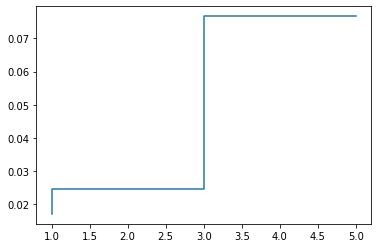

In [34]:
plt.step(x0, y0)
plt.plot()